### This notebook plots the performance of equal shares and utilitarian greedy along with the net impact loss (or gain) across different impact areas at differing levels of project popularity; in terms of budget share, winning rate, cost representation and project representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.2f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.00,0.70,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.00,3.50,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.00,5.00,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.00,39.00,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.00,16.80,True,True,True,NaN,NaN,cumulative


In [6]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN     295110.00            0.00           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
(19110, 22)
(19109, 22)


In [7]:
# compute the values of quartile values of votes distribuion of individual projects per election
q1_df = valid_pbprojects_df.groupby(['election_id'])['votes'].quantile(0.25).reset_index()
q1_df.rename(columns={'votes': 'q1_votes'}, inplace=True)
q1_df['q1_votes'] = np.ceil(q1_df['q1_votes'])
valid_pbprojects_df = valid_pbprojects_df.merge(q1_df, on='election_id', how='inner')

q2_df = valid_pbprojects_df.groupby(['election_id'])['votes'].quantile(0.5).reset_index()
q2_df.rename(columns={'votes': 'q2_votes'}, inplace=True)
q2_df['q2_votes'] = np.ceil(q2_df['q2_votes'])
valid_pbprojects_df = valid_pbprojects_df.merge(q2_df, on='election_id', how='inner')

q3_df = valid_pbprojects_df.groupby(['election_id'])['votes'].quantile(0.75).reset_index()
q3_df.rename(columns={'votes': 'q3_votes'}, inplace=True)
q3_df['q3_votes'] = np.ceil(q3_df['q3_votes'])
valid_pbprojects_df = valid_pbprojects_df.merge(q3_df, on='election_id', how='inner')

q4_df = valid_pbprojects_df.groupby(['election_id'])['votes'].quantile(1).reset_index()
q4_df.rename(columns={'votes': 'q4_votes'}, inplace=True)
q4_df['q4_votes'] = np.ceil(q4_df['q4_votes'])
valid_pbprojects_df = valid_pbprojects_df.merge(q4_df, on='election_id', how='inner')

In [8]:
# total projects cost per election instance
total_projects_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
total_projects_cost.rename(columns={'cost': 'total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

total_projects_count = valid_pbprojects_df.groupby(['election_id'])['project_id'].count().reset_index()
total_projects_count.rename(columns={'project_id': 'total_projects_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_count, on='election_id', how='inner')

# setting additional column for total project costs and count of winners for MES ang UG
# mes_winners_total_cost
mes_winners_total_cost = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
mes_winners_total_cost.rename(columns={'cost': 'mes_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winners_total_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# greedy_winners_total_cost
greedy_total_winners_cost = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
greedy_total_winners_cost.rename(columns={'cost': 'greedy_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# mes winners total count
mes_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
mes_total_winners_count.rename(columns={'project_id': 'mes_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# greedy winners total count
greedy_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
greedy_total_winners_count.rename(columns={'project_id': 'greedy_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

(19109, 27)
(19109, 29)
(19109, 30)
(19109, 31)
(19109, 32)


In [9]:
valid_pbprojects_df['is_popular_q1'] = 0
valid_pbprojects_df['is_popular_q2'] = 0
valid_pbprojects_df['is_popular_q3'] = 0
valid_pbprojects_df['is_popular_q4'] = 0

# based on the quartile level of votes received in an election; assign popularity level to each individual election
for index, row in valid_pbprojects_df.iterrows():
    if row['votes'] <= row['q1_votes']:
        valid_pbprojects_df.at[index, 'is_popular_q1'] = 1
    elif row['votes'] > row['q1_votes'] and row['votes'] <= row['q2_votes']:
        valid_pbprojects_df.at[index, 'is_popular_q2'] = 1
    elif row['votes'] > row['q2_votes'] and row['votes'] <= row['q3_votes']:
        valid_pbprojects_df.at[index, 'is_popular_q3'] = 1
    else:
        valid_pbprojects_df.at[index, 'is_popular_q4'] = 1

In [10]:
# Select only those rows with `category` values
valid_pbprojects_df = valid_pbprojects_df.dropna(subset=['category'])

# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))
print(categories_set)
# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1

valid_pbprojects_df.tail()
print(valid_pbprojects_df.shape)

valid_pbprojects_df.rename(
    columns= {
        'category_education': 'education', 
        'category_public transit and roads': 'public_transit_and_roads', 
        'category_health': 'health', 
        'category_welfare': 'welfare', 
        'category_public space': 'public_space', 
        'category_urban greenery': 'urban_greenery', 
        'category_culture': 'culture', 'category_sport': 'sport', 
        'category_environmental protection': 'env_protection' 
    }, 
    inplace=True
)

{'environmental protection', 'welfare', 'sport', 'urban greenery', 'education', 'health', 'public transit and roads', 'culture', 'public space'}
(10927, 45)


In [11]:
# Some Global Maps
# categories_color_map = {
#     'education': '#d53e4f',
#     'public_transit_and_roads': '#f46d43',
#     'health': '#fdae61',
#     'welfare': '#fee08b',
#     'public_space': '#ffffbf',
#     'urban_greenery': '#e6f598',
#     'culture': '#abdda4',
#     'sport': '#66c2a5',
#     'env_protection': '#3288bd'
# }


categories_color_map = {
    'education': '#3274a1',
    'public_transit_and_roads': '#d684bd',
    'health': '#e1812c',
    'welfare': '#3a923a',
    'public_space': '#845b53',
    'urban_greenery': '#7f7f7f',
    'culture': '#be3e3f',
    'sport': '#9372b2',
    'env_protection': '#a9aa35'
}

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

popularity_quartile_map = {
    'is_popular_q1': 'Unpopular',
    'is_popular_q2': 'Quite Popular',
    'is_popular_q3': 'Popular',
    'is_popular_q4': 'Very Popular'
}

In [12]:
# categories total cost
for category in category_title_map.keys():
    category_total_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True)].groupby(['election_id'])[['cost']].sum()
    category_total_cost.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_total_cost, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_total_cost'].fillna(0, inplace=True)

# categories total count
for category in category_title_map.keys():
    category_total_count = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True)].groupby(['election_id'])[['project_id']].count()
    category_total_count.rename(columns={'project_id': f'{category}_total_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_total_count, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_total_count'].fillna(0, inplace=True)

In [13]:
# Cost and Count of Winning Projects by Both UG and ES across each category
for category in category_title_map.keys():
    category_mes_cost = valid_pbprojects_df[(valid_pbprojects_df[category] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['cost']].sum()
    category_mes_cost.rename(columns={'cost': f'{category}_mes_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_mes_cost, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_mes_cost'].fillna(0, inplace=True)

    category_greedy_cost = valid_pbprojects_df[(valid_pbprojects_df[category] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['cost']].sum()
    category_greedy_cost.rename(columns={'cost': f'{category}_greedy_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_greedy_cost, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_greedy_cost'].fillna(0, inplace=True)

    category_mes_count = valid_pbprojects_df[(valid_pbprojects_df[category] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['project_id']].count()
    category_mes_count.rename(columns={'project_id': f'{category}_mes_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_mes_count, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_mes_count'].fillna(0, inplace=True)

    category_greedy_count = valid_pbprojects_df[(valid_pbprojects_df[category] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['project_id']].count()
    category_greedy_count.rename(columns={'project_id': f'{category}_greedy_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(category_greedy_count, on='election_id', how='left')
    valid_pbprojects_df[f'{category}_greedy_count'].fillna(0, inplace=True)

In [14]:
# overall metrics across each category
for category in category_title_map.keys():
    valid_pbprojects_df[f'{category}_overall_mes_bs'] = valid_pbprojects_df[f'{category}_mes_cost'] / valid_pbprojects_df['mes_total_winners_cost']
    valid_pbprojects_df[f'{category}_overall_greedy_bs'] = valid_pbprojects_df[f'{category}_greedy_cost'] / valid_pbprojects_df['greedy_total_winners_cost']

    valid_pbprojects_df[f'{category}_overall_mes_wr'] = valid_pbprojects_df[f'{category}_mes_count'] / valid_pbprojects_df['mes_total_winners_count']
    valid_pbprojects_df[f'{category}_overall_greedy_wr'] = valid_pbprojects_df[f'{category}_greedy_count'] / valid_pbprojects_df['greedy_total_winners_count']

    valid_pbprojects_df[f'{category}_overall_mes_cr'] = valid_pbprojects_df[f'{category}_mes_cost'] / valid_pbprojects_df[f'{category}_total_cost']
    valid_pbprojects_df[f'{category}_overall_greedy_cr'] = valid_pbprojects_df[f'{category}_greedy_cost'] / valid_pbprojects_df[f'{category}_total_cost']

    valid_pbprojects_df[f'{category}_overall_mes_pr'] = valid_pbprojects_df[f'{category}_mes_count'] / valid_pbprojects_df[f'{category}_total_count']
    valid_pbprojects_df[f'{category}_overall_greedy_pr'] = valid_pbprojects_df[f'{category}_greedy_count'] / valid_pbprojects_df[f'{category}_total_count']

In [15]:
# total projects cost that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    quartile_total_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True)].groupby(['election_id'])[['cost']].sum()
    quartile_total_cost.rename(columns={'cost': f'total_projects_cost_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(quartile_total_cost, on='election_id', how='left')
    valid_pbprojects_df[f'total_projects_cost_{quartile}'].fillna(0, inplace=True)
    
print(valid_pbprojects_df.shape) # shape +4 columns

# total MES winners projects cost that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    total_mes_winners_quartile_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['cost']].sum()
    total_mes_winners_quartile_cost.rename(columns={'cost': f'total_mes_cost_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(total_mes_winners_quartile_cost, on='election_id', how='left')
    valid_pbprojects_df[f'total_mes_cost_{quartile}'].fillna(0, inplace=True)
    
    # secondary loop to proceed through all available categories
    for category in category_title_map.keys():
        category_in_quartile_total_mes_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True) & (valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['cost']].sum()
        category_in_quartile_total_mes_cost.rename(columns={'cost': f'{category}_{quartile}_total_mes_cost'}, inplace=True)
        valid_pbprojects_df = valid_pbprojects_df.merge(category_in_quartile_total_mes_cost, on='election_id', how='left')
        valid_pbprojects_df[f'{category}_{quartile}_total_mes_cost'].fillna(0, inplace=True)

print(valid_pbprojects_df.shape) # +40 columns

# total UG winners projects cost that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    total_ug_winners_quartile_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['cost']].sum()
    total_ug_winners_quartile_cost.rename(columns={'cost': f'total_ug_cost_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(total_ug_winners_quartile_cost, on='election_id', how='left')
    valid_pbprojects_df[f'total_ug_cost_{quartile}'].fillna(0, inplace=True)
    
    # secondary loop to proceed through all available categories
    for category in category_title_map.keys():
        category_in_quartile_total_ug_cost = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True) & (valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['cost']].sum()
        category_in_quartile_total_ug_cost.rename(columns={'cost': f'{category}_{quartile}_total_ug_cost'}, inplace=True)
        valid_pbprojects_df = valid_pbprojects_df.merge(category_in_quartile_total_ug_cost, on='election_id', how='left')
        valid_pbprojects_df[f'{category}_{quartile}_total_ug_cost'].fillna(0, inplace=True)

print(valid_pbprojects_df.shape) # +40 columns

(10927, 175)
(10927, 215)
(10927, 255)


In [16]:
# create a new df such that it contain 1 row per election id and all the cost related columns for BUDGET SHARE by both ug and mes 
# with both quartile and cost level analysis
columns_to_select = ['election_id']

for quartile in popularity_quartile_map.keys():
    columns_to_select.append(f'total_mes_cost_{quartile}')
    columns_to_select.append(f'total_ug_cost_{quartile}')

    for category in category_title_map.keys():
        columns_to_select.append(f'{category}_{quartile}_total_mes_cost')
        columns_to_select.append(f'{category}_{quartile}_total_ug_cost')

print(len(columns_to_select))

budget_share_df = valid_pbprojects_df[columns_to_select]
budget_share_df.drop_duplicates(inplace=True)
print(budget_share_df.shape) # should be 345 x 81

for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        budget_share_df[f'mes_bs_for_{category}_{quartile}'] = 1 * budget_share_df[f'{category}_{quartile}_total_mes_cost'] / budget_share_df[f'total_mes_cost_{quartile}']
        budget_share_df[f'ug_bs_for_{category}_{quartile}'] = 1 * budget_share_df[f'{category}_{quartile}_total_ug_cost'] / budget_share_df[f'total_ug_cost_{quartile}']
        budget_share_df[f'diff_bs_for_{category}_{quartile}'] = budget_share_df[f'ug_bs_for_{category}_{quartile}'] - budget_share_df[f'mes_bs_for_{category}_{quartile}']

print(budget_share_df.shape) # +108 columns

81
(346, 81)
(346, 189)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\756661642.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget_share_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\756661642.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget_share_df[f'mes_bs_for_{category}_{quartile}'] = 1 * budget_share_df[f'{category}_{quartile}_total_mes_cost'] / budget_share_df[f'total_mes_cost_{quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\756661642.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [17]:
cols = []
for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        cols.append(f'mes_bs_for_{category}_{quartile}')
        cols.append(f'ug_bs_for_{category}_{quartile}')
        cols.append(f'diff_bs_for_{category}_{quartile}')

averaged_budget_share_values = budget_share_df[cols].mean()
averaged_budget_share = pd.DataFrame(averaged_budget_share_values).T

mes_averaged_budget_share = averaged_budget_share[[col for col in averaged_budget_share.columns if col.startswith('mes_bs')]]
ug_averaged_budget_share = averaged_budget_share[[col for col in averaged_budget_share.columns if col.startswith('ug_bs')]]
diff_averaged_budget_share = averaged_budget_share[[col for col in averaged_budget_share.columns if col.startswith('diff_bs')]]

print(mes_averaged_budget_share.shape)
print(ug_averaged_budget_share.shape)
print(diff_averaged_budget_share.shape)

(1, 36)
(1, 36)
(1, 36)


In [18]:
# additional columns required in compuatation of WINNING RATE values
# total projects count that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    quartile_total_count = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True)].groupby(['election_id'])[['project_id']].count()
    quartile_total_count.rename(columns={'project_id': f'total_projects_count_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(quartile_total_count, on='election_id', how='left')
    valid_pbprojects_df[f'total_projects_count_{quartile}'].fillna(0, inplace=True)
    
print(valid_pbprojects_df.shape) # shape +4 columns

# total MES winners projects count that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    total_mes_winners_quartile_count = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['project_id']].count()
    total_mes_winners_quartile_count.rename(columns={'project_id': f'total_mes_count_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(total_mes_winners_quartile_count, on='election_id', how='left')
    valid_pbprojects_df[f'total_mes_count_{quartile}'].fillna(0, inplace=True)
    
    # secondary loop to proceed through all available categories
    for category in category_title_map.keys():
        category_in_quartile_total_mes_count = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True) & (valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])[['project_id']].count()
        category_in_quartile_total_mes_count.rename(columns={'project_id': f'{category}_{quartile}_total_mes_count'}, inplace=True)
        valid_pbprojects_df = valid_pbprojects_df.merge(category_in_quartile_total_mes_count, on='election_id', how='left')
        valid_pbprojects_df[f'{category}_{quartile}_total_mes_count'].fillna(0, inplace=True)

print(valid_pbprojects_df.shape) # +40 columns

# total UG winners projects count that lie in respective cost quartiles
for quartile in popularity_quartile_map.keys():
    total_ug_winners_quartile_count = valid_pbprojects_df[(valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['project_id']].count()
    total_ug_winners_quartile_count.rename(columns={'project_id': f'total_ug_count_{quartile}'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(total_ug_winners_quartile_count, on='election_id', how='left')
    valid_pbprojects_df[f'total_ug_count_{quartile}'].fillna(0, inplace=True)
    
    # secondary loop to proceed through all available categories
    for category in category_title_map.keys():
        category_in_quartile_total_ug_count = valid_pbprojects_df[(valid_pbprojects_df[f'{category}'] == True) & (valid_pbprojects_df[f'{quartile}'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])[['project_id']].count()
        category_in_quartile_total_ug_count.rename(columns={'project_id': f'{category}_{quartile}_total_ug_count'}, inplace=True)
        valid_pbprojects_df = valid_pbprojects_df.merge(category_in_quartile_total_ug_count, on='election_id', how='left')
        valid_pbprojects_df[f'{category}_{quartile}_total_ug_count'].fillna(0, inplace=True)

print(valid_pbprojects_df.shape) # +40 columns

(10927, 259)
(10927, 299)
(10927, 339)


In [19]:
# create a new df such that it contain 1 row per election id and all the cost related columns for winning rate by both ug and mes 
# with both quartile and cost level analysis
columns_to_select = ['election_id']

for quartile in popularity_quartile_map.keys():
    columns_to_select.append(f'total_mes_count_{quartile}')
    columns_to_select.append(f'total_ug_count_{quartile}')

    for category in category_title_map.keys():
        columns_to_select.append(f'{category}_{quartile}_total_mes_count')
        columns_to_select.append(f'{category}_{quartile}_total_ug_count')

print(len(columns_to_select))

winning_rate_df = valid_pbprojects_df[columns_to_select]
winning_rate_df.drop_duplicates(inplace=True)
print(winning_rate_df.shape) # should be 345 x 81

for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        winning_rate_df[f'mes_wr_for_{category}_{quartile}'] = 1 * winning_rate_df[f'{category}_{quartile}_total_mes_count'] / winning_rate_df[f'total_mes_count_{quartile}']
        winning_rate_df[f'ug_wr_for_{category}_{quartile}'] = 1 * winning_rate_df[f'{category}_{quartile}_total_ug_count'] / winning_rate_df[f'total_ug_count_{quartile}']
        winning_rate_df[f'diff_wr_for_{category}_{quartile}'] = winning_rate_df[f'ug_wr_for_{category}_{quartile}'] - winning_rate_df[f'mes_wr_for_{category}_{quartile}']
print(winning_rate_df.shape) # +108 columns

81
(346, 81)
(346, 189)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1328786129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_rate_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1328786129.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_rate_df[f'mes_wr_for_{category}_{quartile}'] = 1 * winning_rate_df[f'{category}_{quartile}_total_mes_count'] / winning_rate_df[f'total_mes_count_{quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1328786129.py:22: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [20]:
cols = []
for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        cols.append(f'mes_wr_for_{category}_{quartile}')
        cols.append(f'ug_wr_for_{category}_{quartile}')
        cols.append(f'diff_wr_for_{category}_{quartile}')

averaged_winning_rate_values = winning_rate_df[cols].mean()
averaged_winning_rate = pd.DataFrame(averaged_winning_rate_values).T

mes_averaged_winning_rate = averaged_winning_rate[[col for col in averaged_winning_rate.columns if col.startswith('mes_wr')]]
ug_averaged_winning_rate = averaged_winning_rate[[col for col in averaged_winning_rate.columns if col.startswith('ug_wr')]]
diff_averaged_winning_rate = averaged_winning_rate[[col for col in averaged_winning_rate.columns if col.startswith('diff_wr')]]

print(mes_averaged_winning_rate.shape)
print(ug_averaged_winning_rate.shape)
print(diff_averaged_winning_rate.shape)

(1, 36)
(1, 36)
(1, 36)


In [21]:
# create a new df such that it contain 1 row per election id and all the cost related columns for COST REPRESENTATION by both ug and mes 
# with both quartile and cost level analysis
columns_to_select = ['election_id']

for quartile in popularity_quartile_map.keys():
    columns_to_select.append(f'total_projects_cost_{quartile}')

    for category in category_title_map.keys():
        columns_to_select.append(f'{category}_{quartile}_total_mes_cost')
        columns_to_select.append(f'{category}_{quartile}_total_ug_cost')

print(len(columns_to_select))

cost_representation_df = valid_pbprojects_df[columns_to_select]
cost_representation_df.drop_duplicates(inplace=True)
print(cost_representation_df.shape) # should be 345 x 77

for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        cost_representation_df[f'mes_cr_for_{category}_{quartile}'] = 1 * cost_representation_df[f'{category}_{quartile}_total_mes_cost'] / cost_representation_df[f'total_projects_cost_{quartile}']
        cost_representation_df[f'ug_cr_for_{category}_{quartile}'] = 1 * cost_representation_df[f'{category}_{quartile}_total_ug_cost'] / cost_representation_df[f'total_projects_cost_{quartile}']
        cost_representation_df[f'diff_cr_for_{category}_{quartile}'] = cost_representation_df[f'ug_cr_for_{category}_{quartile}'] - cost_representation_df[f'mes_cr_for_{category}_{quartile}']

print(cost_representation_df.shape) # +72 columns

77
(346, 77)
(346, 185)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1196434357.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_representation_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1196434357.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_representation_df[f'mes_cr_for_{category}_{quartile}'] = 1 * cost_representation_df[f'{category}_{quartile}_total_mes_cost'] / cost_representation_df[f'total_projects_cost_{quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\1196434357.py:21: SettingWithCopyWarning: 
A val

In [22]:
cols = []
for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        cols.append(f'mes_cr_for_{category}_{quartile}')
        cols.append(f'ug_cr_for_{category}_{quartile}')
        cols.append(f'diff_cr_for_{category}_{quartile}')

averaged_cost_representation_values = cost_representation_df[cols].mean()
averaged_cost_representation = pd.DataFrame(averaged_cost_representation_values).T

mes_averaged_cost_representation = averaged_cost_representation[[col for col in averaged_cost_representation.columns if col.startswith('mes_cr')]]
ug_averaged_cost_representation = averaged_cost_representation[[col for col in averaged_cost_representation.columns if col.startswith('ug_cr')]]
diff_averaged_cost_representation = averaged_cost_representation[[col for col in averaged_cost_representation.columns if col.startswith('diff_cr')]]

print(mes_averaged_cost_representation.shape)
print(ug_averaged_cost_representation.shape)
print(diff_averaged_cost_representation.shape)

(1, 36)
(1, 36)
(1, 36)


In [23]:
# create a new df such that it contain 1 row per election id and all the cost related columns for PROJECT REPRESENTATION by both ug and mes 
# with both quartile and cost level analysis
columns_to_select = ['election_id']

for quartile in popularity_quartile_map.keys():
    columns_to_select.append(f'total_projects_count_{quartile}')

    for category in category_title_map.keys():
        columns_to_select.append(f'{category}_{quartile}_total_mes_count')
        columns_to_select.append(f'{category}_{quartile}_total_ug_count')

print(len(columns_to_select))

project_representation_df = valid_pbprojects_df[columns_to_select]
project_representation_df.drop_duplicates(inplace=True)
print(project_representation_df.shape) # should be 345 x 77

for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        project_representation_df[f'mes_pr_for_{category}_{quartile}'] = 1 * project_representation_df[f'{category}_{quartile}_total_mes_count'] / project_representation_df[f'total_projects_count_{quartile}']
        project_representation_df[f'ug_pr_for_{category}_{quartile}'] = 1 * project_representation_df[f'{category}_{quartile}_total_ug_count'] / project_representation_df[f'total_projects_count_{quartile}']
        project_representation_df[f'diff_pr_for_{category}_{quartile}'] = project_representation_df[f'ug_pr_for_{category}_{quartile}'] - project_representation_df[f'mes_pr_for_{category}_{quartile}']

print(project_representation_df.shape) # +108 columns

77
(346, 77)
(346, 185)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\3294139242.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_representation_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\3294139242.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_representation_df[f'mes_pr_for_{category}_{quartile}'] = 1 * project_representation_df[f'{category}_{quartile}_total_mes_count'] / project_representation_df[f'total_projects_count_{quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_6796\3294139242.py:21: SettingWithCopyW

In [24]:
cols = []
for quartile in popularity_quartile_map.keys():
    for category in category_title_map.keys():
        cols.append(f'mes_pr_for_{category}_{quartile}')
        cols.append(f'ug_pr_for_{category}_{quartile}')
        cols.append(f'diff_pr_for_{category}_{quartile}')

averaged_project_representation_values = project_representation_df[cols].mean()
averaged_project_representation = pd.DataFrame(averaged_project_representation_values).T

mes_averaged_project_representation = averaged_project_representation[[col for col in averaged_project_representation.columns if col.startswith('mes_pr')]]
ug_averaged_project_representation = averaged_project_representation[[col for col in averaged_project_representation.columns if col.startswith('ug_pr')]]
diff_averaged_project_representation = averaged_project_representation[[col for col in averaged_project_representation.columns if col.startswith('diff_pr')]]

print(mes_averaged_project_representation.shape)
print(ug_averaged_project_representation.shape)
print(diff_averaged_project_representation.shape)

(1, 36)
(1, 36)
(1, 36)


## Plot for cost control of impact areas and their performance along with net loss or gain for impact metrics

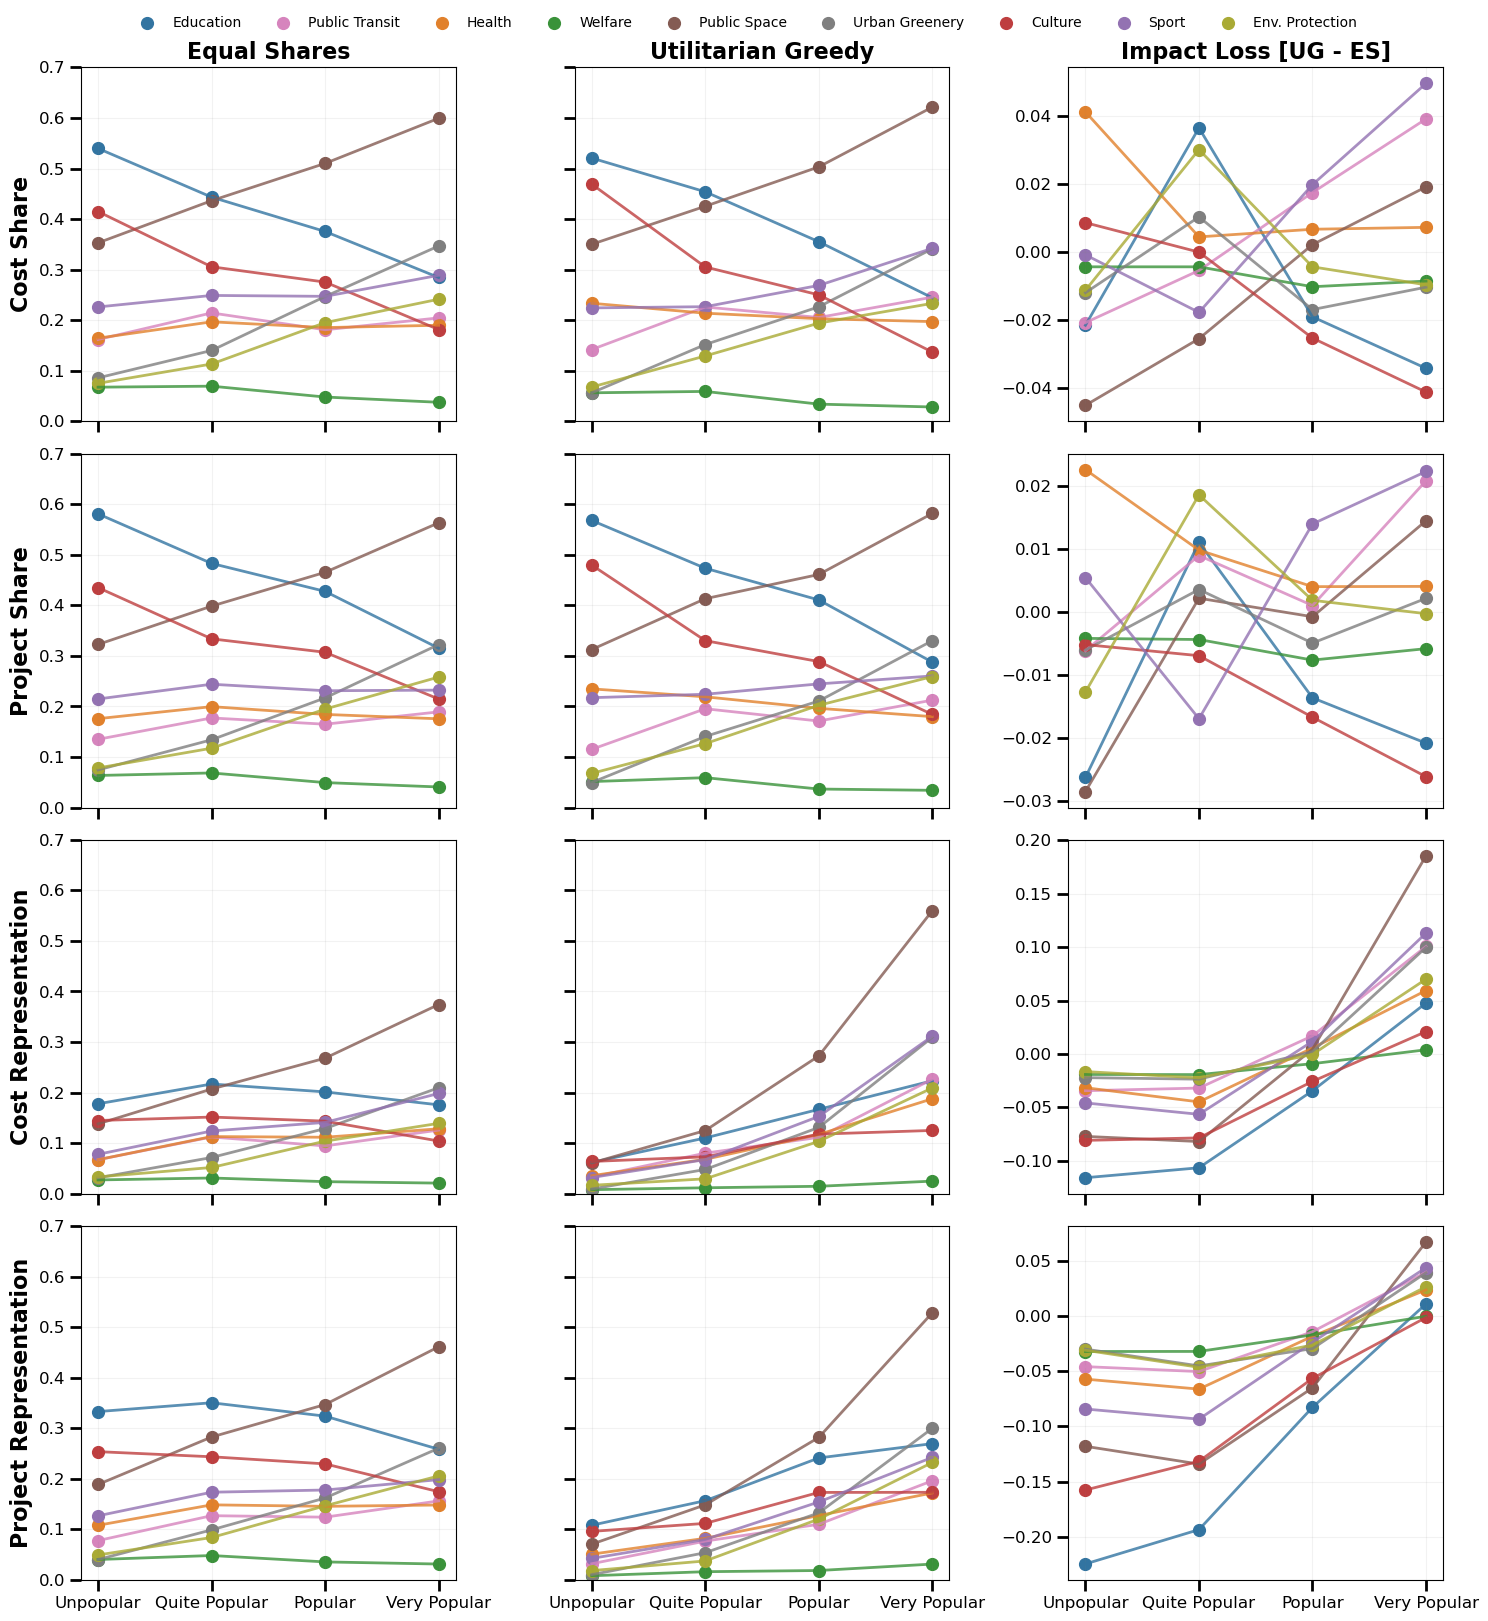

In [25]:
fig, ax = plt.subplots(4, 3, figsize=(15, 16), sharex=True)

## first plot; budget share
bs_mes_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

bs_ug_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

bs_diff_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

for i, (qk, qv) in enumerate(popularity_quartile_map.items()):
    for j, (ck, cv) in enumerate(category_title_map.items()):
        # populate four quartile values for each of the categories for MES; to be used while connecting lines
        if not bs_mes_category_quartiles_values[ck]:
            bs_mes_category_quartiles_values[ck].append(mes_averaged_budget_share[f'mes_bs_for_{ck}_is_popular_q1'].iloc[0])
            bs_mes_category_quartiles_values[ck].append(mes_averaged_budget_share[f'mes_bs_for_{ck}_is_popular_q2'].iloc[0])
            bs_mes_category_quartiles_values[ck].append(mes_averaged_budget_share[f'mes_bs_for_{ck}_is_popular_q3'].iloc[0])
            bs_mes_category_quartiles_values[ck].append(mes_averaged_budget_share[f'mes_bs_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not bs_ug_category_quartiles_values[ck]:
            bs_ug_category_quartiles_values[ck].append(ug_averaged_budget_share[f'ug_bs_for_{ck}_is_popular_q1'].iloc[0])
            bs_ug_category_quartiles_values[ck].append(ug_averaged_budget_share[f'ug_bs_for_{ck}_is_popular_q2'].iloc[0])
            bs_ug_category_quartiles_values[ck].append(ug_averaged_budget_share[f'ug_bs_for_{ck}_is_popular_q3'].iloc[0])
            bs_ug_category_quartiles_values[ck].append(ug_averaged_budget_share[f'ug_bs_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not bs_diff_category_quartiles_values[ck]:
            bs_diff_category_quartiles_values[ck].append(diff_averaged_budget_share[f'diff_bs_for_{ck}_is_popular_q1'].iloc[0])
            bs_diff_category_quartiles_values[ck].append(diff_averaged_budget_share[f'diff_bs_for_{ck}_is_popular_q2'].iloc[0])
            bs_diff_category_quartiles_values[ck].append(diff_averaged_budget_share[f'diff_bs_for_{ck}_is_popular_q3'].iloc[0])
            bs_diff_category_quartiles_values[ck].append(diff_averaged_budget_share[f'diff_bs_for_{ck}_is_popular_q4'].iloc[0])
        
        # additional condition check only for labels
        if i == 0:
            ax[0][0].scatter([i], mes_averaged_budget_share[f'mes_bs_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[0][1].scatter([i], ug_averaged_budget_share[f'ug_bs_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[0][2].scatter([i], diff_averaged_budget_share[f'diff_bs_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
        else:
            ax[0][0].scatter([i], mes_averaged_budget_share[f'mes_bs_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[0][1].scatter([i], ug_averaged_budget_share[f'ug_bs_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[0][2].scatter([i], diff_averaged_budget_share[f'diff_bs_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])

# the line connecting corresponding categories
for k, (ck, cv) in enumerate(category_title_map.items()):
    ax[0][0].plot(range(len(popularity_quartile_map.keys())), bs_mes_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[0][1].plot(range(len(popularity_quartile_map.keys())), bs_ug_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[0][2].plot(range(len(popularity_quartile_map.keys())), bs_diff_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)


ax[0][0].set_xticks(range(len(popularity_quartile_map.keys())))
ax[0][0].set_title('Equal Shares', fontsize=16, fontweight='bold')
ax[0][1].set_title('Utilitarian Greedy', fontsize=16, fontweight='bold')
ax[0][2].set_title('Impact Loss [UG - ES]', fontsize=16, fontweight='bold')
ax[0][0].tick_params(axis='both', labelsize=14)
ax[0][1].tick_params(axis='both', labelsize=14)
ax[0][2].tick_params(axis='both', labelsize=14)
ax[0][0].set_ylabel('Cost Share', fontsize=16, fontweight='bold')
ax[0][0].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[0][1].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[0][2].grid(axis='both', which='major', color='gray', alpha=0.1)
## end of first plot

## second plot; winning rate
wr_mes_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

wr_ug_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

wr_diff_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

for i, (qk, qv) in enumerate(popularity_quartile_map.items()):
    for j, (ck, cv) in enumerate(category_title_map.items()):
        # populate four quartile values for each of the categories for MES; to be used while connecting lines
        if not wr_mes_category_quartiles_values[ck]:
            wr_mes_category_quartiles_values[ck].append(mes_averaged_winning_rate[f'mes_wr_for_{ck}_is_popular_q1'].iloc[0])
            wr_mes_category_quartiles_values[ck].append(mes_averaged_winning_rate[f'mes_wr_for_{ck}_is_popular_q2'].iloc[0])
            wr_mes_category_quartiles_values[ck].append(mes_averaged_winning_rate[f'mes_wr_for_{ck}_is_popular_q3'].iloc[0])
            wr_mes_category_quartiles_values[ck].append(mes_averaged_winning_rate[f'mes_wr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not wr_ug_category_quartiles_values[ck]:
            wr_ug_category_quartiles_values[ck].append(ug_averaged_winning_rate[f'ug_wr_for_{ck}_is_popular_q1'].iloc[0])
            wr_ug_category_quartiles_values[ck].append(ug_averaged_winning_rate[f'ug_wr_for_{ck}_is_popular_q2'].iloc[0])
            wr_ug_category_quartiles_values[ck].append(ug_averaged_winning_rate[f'ug_wr_for_{ck}_is_popular_q3'].iloc[0])
            wr_ug_category_quartiles_values[ck].append(ug_averaged_winning_rate[f'ug_wr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not wr_diff_category_quartiles_values[ck]:
            wr_diff_category_quartiles_values[ck].append(diff_averaged_winning_rate[f'diff_wr_for_{ck}_is_popular_q1'].iloc[0])
            wr_diff_category_quartiles_values[ck].append(diff_averaged_winning_rate[f'diff_wr_for_{ck}_is_popular_q2'].iloc[0])
            wr_diff_category_quartiles_values[ck].append(diff_averaged_winning_rate[f'diff_wr_for_{ck}_is_popular_q3'].iloc[0])
            wr_diff_category_quartiles_values[ck].append(diff_averaged_winning_rate[f'diff_wr_for_{ck}_is_popular_q4'].iloc[0])
        
        # additional condition check only for labels
        if i == 0:
            ax[1][0].scatter([i], mes_averaged_winning_rate[f'mes_wr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[1][1].scatter([i], ug_averaged_winning_rate[f'ug_wr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[1][2].scatter([i], diff_averaged_winning_rate[f'diff_wr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
        else:
            ax[1][0].scatter([i], mes_averaged_winning_rate[f'mes_wr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[1][1].scatter([i], ug_averaged_winning_rate[f'ug_wr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[1][2].scatter([i], diff_averaged_winning_rate[f'diff_wr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])

# the line connecting corresponding categories
for k, (ck, cv) in enumerate(category_title_map.items()):
    ax[1][0].plot(range(len(popularity_quartile_map.keys())), wr_mes_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[1][1].plot(range(len(popularity_quartile_map.keys())), wr_ug_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[1][2].plot(range(len(popularity_quartile_map.keys())), wr_diff_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)

ax[1][0].set_xticks(range(len(popularity_quartile_map.keys())))
ax[1][0].tick_params(axis='both', labelsize=14)
ax[1][1].tick_params(axis='both', labelsize=14)
ax[1][2].tick_params(axis='both', labelsize=14)
ax[1][0].set_ylabel('Project Share', fontsize=16, fontweight='bold')
ax[1][0].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[1][1].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[1][2].grid(axis='both', which='major', color='gray', alpha=0.1)
## end of second plot

## third plot; cost representation
cr_mes_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

cr_ug_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

cr_diff_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

for i, (qk, qv) in enumerate(popularity_quartile_map.items()):
    for j, (ck, cv) in enumerate(category_title_map.items()):
        # populate four quartile values for each of the categories for MES; to be used while connecting lines
        if not cr_mes_category_quartiles_values[ck]:
            cr_mes_category_quartiles_values[ck].append(mes_averaged_cost_representation[f'mes_cr_for_{ck}_is_popular_q1'].iloc[0])
            cr_mes_category_quartiles_values[ck].append(mes_averaged_cost_representation[f'mes_cr_for_{ck}_is_popular_q2'].iloc[0])
            cr_mes_category_quartiles_values[ck].append(mes_averaged_cost_representation[f'mes_cr_for_{ck}_is_popular_q3'].iloc[0])
            cr_mes_category_quartiles_values[ck].append(mes_averaged_cost_representation[f'mes_cr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not cr_ug_category_quartiles_values[ck]:
            cr_ug_category_quartiles_values[ck].append(ug_averaged_cost_representation[f'ug_cr_for_{ck}_is_popular_q1'].iloc[0])
            cr_ug_category_quartiles_values[ck].append(ug_averaged_cost_representation[f'ug_cr_for_{ck}_is_popular_q2'].iloc[0])
            cr_ug_category_quartiles_values[ck].append(ug_averaged_cost_representation[f'ug_cr_for_{ck}_is_popular_q3'].iloc[0])
            cr_ug_category_quartiles_values[ck].append(ug_averaged_cost_representation[f'ug_cr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for DIFF; to be used while connecting lines
        if not cr_diff_category_quartiles_values[ck]:
            cr_diff_category_quartiles_values[ck].append(diff_averaged_cost_representation[f'diff_cr_for_{ck}_is_popular_q1'].iloc[0])
            cr_diff_category_quartiles_values[ck].append(diff_averaged_cost_representation[f'diff_cr_for_{ck}_is_popular_q2'].iloc[0])
            cr_diff_category_quartiles_values[ck].append(diff_averaged_cost_representation[f'diff_cr_for_{ck}_is_popular_q3'].iloc[0])
            cr_diff_category_quartiles_values[ck].append(diff_averaged_cost_representation[f'diff_cr_for_{ck}_is_popular_q4'].iloc[0])
        
        # additional condition check only for labels
        if i == 0:
            ax[2][0].scatter([i], mes_averaged_cost_representation[f'mes_cr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[2][1].scatter([i], ug_averaged_cost_representation[f'ug_cr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[2][2].scatter([i], diff_averaged_cost_representation[f'diff_cr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
        else:
            ax[2][0].scatter([i], mes_averaged_cost_representation[f'mes_cr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[2][1].scatter([i], ug_averaged_cost_representation[f'ug_cr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[2][2].scatter([i], diff_averaged_cost_representation[f'diff_cr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])

# the line connecting corresponding categories
for k, (ck, cv) in enumerate(category_title_map.items()):
    ax[2][0].plot(range(len(popularity_quartile_map.keys())), cr_mes_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[2][1].plot(range(len(popularity_quartile_map.keys())), cr_ug_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[2][2].plot(range(len(popularity_quartile_map.keys())), cr_diff_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)

ax[2][0].set_xticks(range(len(popularity_quartile_map.keys())))
ax[2][0].tick_params(axis='both', labelsize=14)
ax[2][1].tick_params(axis='both', labelsize=14)
ax[2][2].tick_params(axis='both', labelsize=14)
ax[2][0].set_ylabel('Cost Representation', fontsize=16, fontweight='bold')
ax[2][0].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[2][1].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[2][2].grid(axis='both', which='major', color='gray', alpha=0.1)
## end of third plot

## fourth plot; project representation
pr_mes_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

pr_ug_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

pr_diff_category_quartiles_values = {
    'education': [],
    'public_transit_and_roads': [],
    'health': [],
    'welfare': [],
    'public_space': [],
    'urban_greenery': [],
    'culture': [],
    'sport': [],
    'env_protection': []
}

# only appending data
for i, (qk, qv) in enumerate(popularity_quartile_map.items()):
    for j, (ck, cv) in enumerate(category_title_map.items()):
        # populate four quartile values for each of the categories for MES; to be used while connecting lines
        if not pr_mes_category_quartiles_values[ck]:
            pr_mes_category_quartiles_values[ck].append(mes_averaged_project_representation[f'mes_pr_for_{ck}_is_popular_q1'].iloc[0])
            pr_mes_category_quartiles_values[ck].append(mes_averaged_project_representation[f'mes_pr_for_{ck}_is_popular_q2'].iloc[0])
            pr_mes_category_quartiles_values[ck].append(mes_averaged_project_representation[f'mes_pr_for_{ck}_is_popular_q3'].iloc[0])
            pr_mes_category_quartiles_values[ck].append(mes_averaged_project_representation[f'mes_pr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for UG; to be used while connecting lines
        if not pr_ug_category_quartiles_values[ck]:
            pr_ug_category_quartiles_values[ck].append(ug_averaged_project_representation[f'ug_pr_for_{ck}_is_popular_q1'].iloc[0])
            pr_ug_category_quartiles_values[ck].append(ug_averaged_project_representation[f'ug_pr_for_{ck}_is_popular_q2'].iloc[0])
            pr_ug_category_quartiles_values[ck].append(ug_averaged_project_representation[f'ug_pr_for_{ck}_is_popular_q3'].iloc[0])
            pr_ug_category_quartiles_values[ck].append(ug_averaged_project_representation[f'ug_pr_for_{ck}_is_popular_q4'].iloc[0])

        # populate four quartile values for each of the categories for DIFF; to be used while connecting lines
        if not pr_diff_category_quartiles_values[ck]:
            pr_diff_category_quartiles_values[ck].append(diff_averaged_project_representation[f'diff_pr_for_{ck}_is_popular_q1'].iloc[0])
            pr_diff_category_quartiles_values[ck].append(diff_averaged_project_representation[f'diff_pr_for_{ck}_is_popular_q2'].iloc[0])
            pr_diff_category_quartiles_values[ck].append(diff_averaged_project_representation[f'diff_pr_for_{ck}_is_popular_q3'].iloc[0])
            pr_diff_category_quartiles_values[ck].append(diff_averaged_project_representation[f'diff_pr_for_{ck}_is_popular_q4'].iloc[0])

        # additional condition check only for labels
        if i == 0:
            ax[3][0].scatter([i], mes_averaged_project_representation[f'mes_pr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[3][1].scatter([i], ug_averaged_project_representation[f'ug_pr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
            ax[3][2].scatter([i], diff_averaged_project_representation[f'diff_pr_for_{ck}_{qk}'], label=cv, s=72, color=categories_color_map[ck])
        else:
            ax[3][0].scatter([i], mes_averaged_project_representation[f'mes_pr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[3][1].scatter([i], ug_averaged_project_representation[f'ug_pr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
            ax[3][2].scatter([i], diff_averaged_project_representation[f'diff_pr_for_{ck}_{qk}'], s=72, color=categories_color_map[ck])
        
# the line connecting corresponding categories
for k, (ck, cv) in enumerate(category_title_map.items()):
    ax[3][0].plot(range(len(popularity_quartile_map.keys())), pr_mes_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[3][1].plot(range(len(popularity_quartile_map.keys())), pr_ug_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    ax[3][2].plot(range(len(popularity_quartile_map.keys())), pr_diff_category_quartiles_values[ck], linestyle='-', color=categories_color_map[ck], linewidth=2, alpha=0.8)
    

ax[3][0].set_xticks(range(len(popularity_quartile_map.keys())))
ax[3][0].set_xticklabels(['Unpopular', 'Quite Popular', 'Popular', 'Very Popular'])
ax[3][0].tick_params(axis='y', labelsize=14)
ax[3][1].tick_params(axis='y', labelsize=14)
ax[3][2].tick_params(axis='y', labelsize=14)
ax[3][0].set_ylabel('Project Representation', fontsize=16, fontweight='bold')
ax[3][0].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[3][1].grid(axis='both', which='major', color='gray', alpha=0.1)
ax[3][2].grid(axis='both', which='major', color='gray', alpha=0.1)

# setting y-lims
ax[0][0].set_ylim([0, 0.7])
ax[0][1].set_ylim([0, 0.7])
ax[0][1].set_yticklabels([])

ax[1][0].set_ylim([0, 0.7])
ax[1][1].set_ylim([0, 0.7])
ax[1][1].set_yticklabels([])

ax[2][0].set_ylim([0, 0.7])
ax[2][1].set_ylim([0, 0.7])
ax[2][1].set_yticklabels([])

ax[3][0].set_ylim([0, 0.7])
ax[3][1].set_ylim([0, 0.7])
ax[3][1].set_yticklabels([])

# set y-ticks size
for i in range(4):
    for j in range(3):
        ax[i][j].tick_params(axis='both', length=8, width=2, labelsize=12)

# Customize legend
handles, labels = ax[3][2].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.99), ncols=9, frameon=False)
## end of fourth plot; project representation

plt.tight_layout()
plt.show()